# Computational Exercise 10: A Simple Word Embedding Based Model

---
In this exercise, we'll continue working with the "PubMed 200k RCT dataset", but this time, we'll apply a model that's based on word *embeddings* rather than word *counts*.

Goals of the exercise are as follows:

- Load word embeddings and see how they can be used to convert text into a numeric array
- Train and evaluate a VSWEM model, in which all word embeddings in a given document are aggregated to create a fixed-length feature vector
- Train and evaluate a SWEM model, in which word embeddings are refined, then aggregated to create a fixed-length feature vector

We'll need Tensorflow to train SWEM, so you may want to complete this exercise in Colab.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import requests, shutil

The next couple of blocks will load the dataset. We've seen this code several times.

In [2]:
train_url = 'https://github.com/Franck-Dernoncourt/pubmed-rct/raw/master/PubMed_20k_RCT/train.txt?raw=true'
val_url = 'https://github.com/Franck-Dernoncourt/pubmed-rct/raw/master/PubMed_20k_RCT/dev.txt?raw=true'
test_url = 'https://github.com/Franck-Dernoncourt/pubmed-rct/raw/master/PubMed_20k_RCT/test.txt?raw=true'

In [3]:
def read_pubmed_rct(url):

    labels = []
    sentences = []
    
    with requests.get(url) as r:
        for line in r.iter_lines():
            fields = line.decode('utf-8').strip().split('\t')
            if len(fields) == 2:
                labels.append(fields[0])
                sentences.append(fields[1])
                
    return sentences, labels

s_train, l_train = read_pubmed_rct(train_url)
s_val, l_val = read_pubmed_rct(val_url)
s_test, l_test = read_pubmed_rct(test_url)

print('There are %i sentences in the training set' % len(s_train))
print('There are %i sentences in the validation set' % len(s_val))
print('There are %i sentences in the test set' % len(s_test))

There are 180040 sentences in the training set
There are 30212 sentences in the validation set
There are 30135 sentences in the test set


## Exercise 10.1: Sentence Length (in characters)

Most of the time in natural language processing, we need to set a limit on how long are documents are allowed to be so that we can tell our model how big of an input it should expect. To get an initial sense of the length of our documents -- which in this case are sentences from PubMed abstracts -- let's plot a histogram of the sentence lengths (in characters) for the sentences in our training set. Note that the length of a single sentence can be determined with `len(sentence)`.

In the code block below, you should:

1. Calculate the length of all sentences in `s_train` using a list comprehension
2. Use `plt.hist` to plot the lengths as a histogram

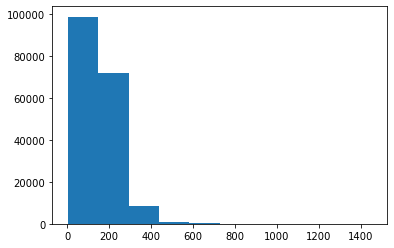

In [4]:
### CALCULATE THE LENGTH OF EACH SENTENCE ###

lengths = [len(s) for s in s_train]

### CREATE A HISTOGRAM SHOWING SENTENCE LENGTH IN THE TRAINING SET ###

plt.hist(lengths)
plt.show()

## Word Embeddings

Now let's load our word vectors/embeddings. We'll use the same 300-dimensional embeddings from the Stanford NLP group (i.e. GloVe) that we used in Activity 10. No need to worry about how we're loading the file, but it's important to note that we can look up the vector for `'word'` by writing `glove_dict['word']`. For more details on this, please refer to Activity 10.

In [5]:
response = requests.get(
    'https://github.com/mengelhard/mmci_applied_ds/raw/master/data/glove/ce3_glove.npy',
    stream=True)

with open('glove.npy', 'wb') as fin:
    shutil.copyfileobj(response.raw, fin)

glove_dict = np.load('glove.npy', allow_pickle=True).item()

## Exercise 10.2: Sentence Length (in embeddings)

We already know how long in characters our sentences tend to be, but the limit we'll need to place on the sentence length will be in terms of the maximimum number of *embeddings*.

In the code block below, you should:
1. Calculate the number of GloVe embeddings in each sentence using a list comprehension
  - Use either `sentence.split()` or `word_tokenize` from `nltk` (see CE9) to tokenize the sentences
  - Remember to convert all words to `.lower()` before checking whether a word is in `glove_dict.keys()` or attempting to retrieve the corresponding word vector
  - Words should be counted only if they're in `glove_dict.keys()`
2. Use `plt.hist` to plot the lengths as a histogram

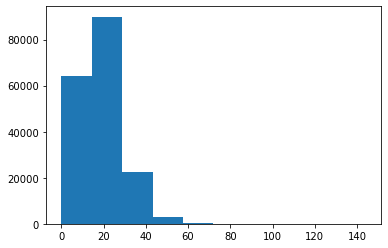

In [6]:
### COUNT THE NUMBER OF GloVe EMBEDDINGS IN EACH SENTENCE ###

lengths = [len([w for w in s.split() if w.lower() in glove_dict.keys()]) for s in s_train]

### CREATE A HISTOGRAM SHOWING THESE COUNTS ACROSS THE TRAINING SET ###

plt.hist(lengths)
plt.show()

## Preparing the sentences for modeling

The code below will convert each sentence in our dataset into a 40 by 300 array. First, all words in `glove_dict().keys()` are converted into word embeddings, each of which has length 300. Then, we stack all these embeddings together into an N by 300 array, where N is the number of embeddings we were able to retrieve from the words in the current sentence. Finally, if N is greater than 40, we'll use only the first 40 embeddings, and if N is less than 40, we'll pad with zeros to get a 40 by 300 array.

The details of this block are not critical, but it may be helpful to think through these details carefully, particularly if you plan to work with your own NLP models. A few additional notes:
- We are discarding sentences with 0 embeddings (i.e. N = 0)
- We could choose `max_length` to be something other than 40. If you believe a different number might be better based the histogram you plotted in 10.2, please change this value. Note that this value is a hyperparameter of our model.

In [7]:
y_dict = {'BACKGROUND': 0, 'OBJECTIVE': 1, 'METHODS': 2, 'RESULTS': 3, 'CONCLUSIONS': 4}


def embed_sentence(s, max_length=40, embedding_dim=300):
    
    arr = [glove_dict[w.lower()] for w in s.split() if w.lower() in glove_dict.keys()]
    arr = arr[:max_length]
    
    pad_length = max_length - len(arr)
    pad = np.zeros((pad_length, embedding_dim))

    return np.concatenate((arr, pad)) if len(arr) > 0 else None
    
    
def process_sentences_and_labels(sentences, labels):
    
    embedded = [embed_sentence(s) for s in sentences]
    x = np.stack([x for x in embedded if x is not None])
    y = np.array([y_dict[l] for l, x in zip(labels, embedded) if x is not None])
    
    return x, y


x_train, y_train = process_sentences_and_labels(s_train, l_train)
x_val, y_val = process_sentences_and_labels(s_val, l_val)
x_test, y_test = process_sentences_and_labels(s_test, l_test)

Let's quickly verify that the result came out as expected. `x_train`, `x_val`, and `x_test` should all have 3 dimensions. Take a moment to think about these arrays and what each dimension within them represents.

In [8]:
x_train.shape, x_val.shape, x_test.shape

((178988, 40, 300), (30024, 40, 300), (29946, 40, 300))

## Exercise 10.3: A *very* simple word embedding based model (VSWEM)

We're now ready to train our VSWEM model. In the block below, you should:
1. Convert `x_train`, `x_val`, and `x_test` into 2-dimensional (rather than 3-dimensional) arrays by applying taking *either* the max or the average over `axis=1` (consider: why axis 1?)
2. Train `LogisticRegression` or another model of your choice (e.g. `MLPClassifier`) on the training set, then evaluate its performance on the validation set
3. (**optional**) Explore different models or variations, then evaluate your best performing model (as determined on the validation set) on the test set. One variation could be to concatenate the max and average into a single, 600-dimensional vector.

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

### USE A SUMMARY STATISTIC OF YOUR CHOICE TO AGGREGATE ACROSS AXIS 1 ###

x_train_swem = np.concatenate([x_train.mean(axis=1), x_train.max(axis=1)], axis=1)
x_val_swem = np.concatenate([x_val.mean(axis=1), x_val.max(axis=1)], axis=1)

### TRAIN A MODEL OF YOUR CHOICE ON THE TRAINING SET ###

mlp_model = MLPClassifier(early_stopping=True).fit(x_train_swem, y_train)

### EVALUATE PERFORMANCE ON THE VALIDATION SET ###

accuracy = np.mean(mlp_model.predict(x_val_swem) == y_val)
print('The accuracy is %.1f' % (100 * accuracy))

The accuracy is 77.8


## Exercise 10.4: A simple word embedding based model (SWEM)

VSWEM is simple, but it doesn't work very well. We'll get much better performance by adding a fully connected layer that *refines* each word embedding before pooling them all together. To do this, however, we'll need TensorFlow. The following two blocks are ready to go. The first block creates the model, converts our data into TensorFlow datasets, and defines the loss and optimizer. The second block then trains the model (for two Epochs) while evaluating performance on the training validation sets.

For full credit, you need only (a) read through each block, then (b) run them both and observe the result. **Optionally**, you can explore this code further by modifying one or more elements of the model.

In [10]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import GlobalMaxPool1D, GlobalAveragePooling1D
from tensorflow.keras import Model


# define SWEM
class SWEM(Model):
    def __init__(self):
        super(SWEM, self).__init__()
        self.fc1 = Dense(300, activation='relu')
        self.mp = GlobalMaxPool1D()
        self.ap = GlobalAveragePooling1D()
        self.fc2 = Dense(5, activation=None)

    def call(self, x):
        x = self.fc1(x)
        xm = self.mp(x)
        xa = self.ap(x)
        x = tf.concat([xm, xa], axis=1)
        return self.fc2(x)
    

# create an instance of SWEM
model = SWEM()

# create tensorflow datasets
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train.astype('float32'), y_train)).batch(32)

val_ds = tf.data.Dataset.from_tensor_slices(
    (x_val.astype('float32'), y_val)).batch(32)

test_ds = tf.data.Dataset.from_tensor_slices(
    (x_test.astype('float32'), y_test)).batch(32)

# multi-class cross-entropy loss
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# modified stochastic gradient descent optimizer
optimizer = tf.keras.optimizers.Adam()

In [11]:
EPOCHS = 2

for epoch in range(EPOCHS):

    train_accuracy = []
    val_accuracy = []
  
    for i, (x, y) in enumerate(train_ds):
        
        print('Running training batch %i of %i' % (i, len(train_ds)), end='\r')
    
        with tf.GradientTape() as tape:
            predicted_logits = model(x)
            loss = loss_object(y, predicted_logits)

        y_pred = np.argmax(predicted_logits, axis=1)
        batch_accuracy = np.mean(y_pred == y)
        train_accuracy.append(batch_accuracy)
    
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    for i, (x, y) in enumerate(val_ds):
        
        print('Running validation batch %i of %i' % (i, len(val_ds)), end='\r')
    
        predicted_logits = model(x)
        y_pred = np.argmax(predicted_logits, axis=1)
    
        batch_accuracy = np.mean(y_pred == y)
        val_accuracy.append(batch_accuracy)

    train_accuracy = 100 * np.mean(train_accuracy)
    val_accuracy = 100 * np.mean(val_accuracy)
        
    print('Epoch %i: train accuracy = %.1f%%, validation accuracy = %.1f%%' % (
        epoch, train_accuracy, val_accuracy))

Epoch 0: train accuracy = 76.3%, validation accuracy = 79.0%
Epoch 1: train accuracy = 80.2%, validation accuracy = 80.1%


### Once you've completed these exercises, please turn in the assignment as follows:

If you're using Anaconda on your local machine:
- download your notebook as html (see File > Download as > HTML (.html))
- submit the resulting file as your assignment
- if .html files are not accepted, .zip the file (i.e. place it in a .zip archive) and submit the .zip file instead

If you're using Google Colab:
- download your notebook as .ipynb (see File > Download > Download .ipynb)
- if you have nbconvert installed, convert it to .html; if not, leave is as .ipynb
- submit the resulting file as your assignment
- if this file is not accepted, .zip the file (i.e. place it in a .zip archive) and submit the .zip file instead